# BLE Proximity Experiment - SVR
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../dataset_train_university.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,4.5,-86,-86.000000,Public,4.5
1,0.0,4.5,-84,-85.000000,Public,4.5
2,0.0,4.5,-83,-84.333333,Public,4.5
3,0.0,4.5,-84,-84.250000,Public,4.5
4,0.0,4.5,-92,-85.800000,Public,4.5
...,...,...,...,...,...,...
3672,0.0,0.0,-57,-56.814815,Personal,0.0
3673,0.0,0.0,-56,-56.785714,Personal,0.0
3674,0.0,0.0,-56,-56.758621,Personal,0.0
3675,0.0,0.0,-56,-56.733333,Personal,0.0


(3677, 6)

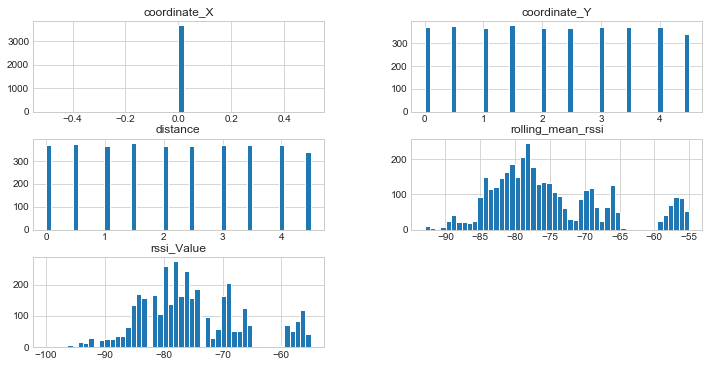

In [5]:
test_dataset = load_file('../../dataset_test_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | BIG DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,Personal,0.0
1,0.0,0.0,-46,-46.500000,Personal,0.0
2,0.0,0.0,-46,-46.333333,Personal,0.0
3,0.0,0.0,-47,-46.500000,Personal,0.0
4,0.0,0.0,-47,-46.600000,Personal,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,Social,3.5
12471,0.0,3.5,-87,-84.684211,Social,3.5
12472,0.0,3.5,-87,-84.800000,Social,3.5
12473,0.0,3.5,-87,-84.904762,Social,3.5


(12475, 6)

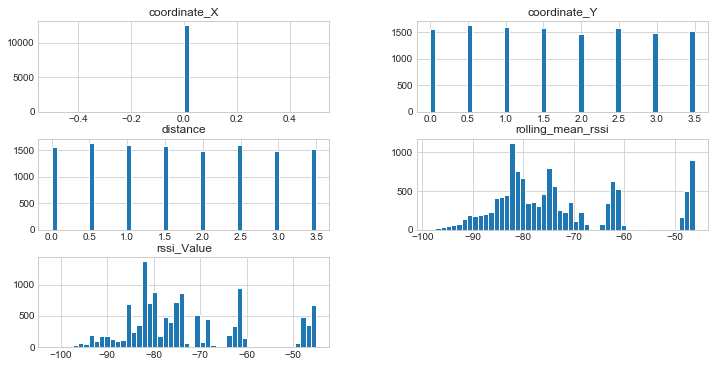

In [6]:
test_dataset_home_big = load_file('../../dataset_test_home_big.csv')
positions = test_dataset_home_big['coordinate_Y']
test_dataset_home_big['distance'] = positions
replace_features_nan(test_dataset_home_big)
display(test_dataset_home_big)
display(test_dataset_home_big.shape)
test_dataset_home_big.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,Personal,0.0
1,0.0,0.0,-44,-44.000000,Personal,0.0
2,0.0,0.0,-44,-44.000000,Personal,0.0
3,0.0,0.0,-44,-44.000000,Personal,0.0
4,0.0,0.0,-45,-44.200000,Personal,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,Social,3.5
2280,0.0,3.5,-85,-84.000000,Social,3.5
2281,0.0,3.5,-85,-84.050000,Social,3.5
2282,0.0,3.5,-92,-84.428571,Social,3.5


(2284, 6)

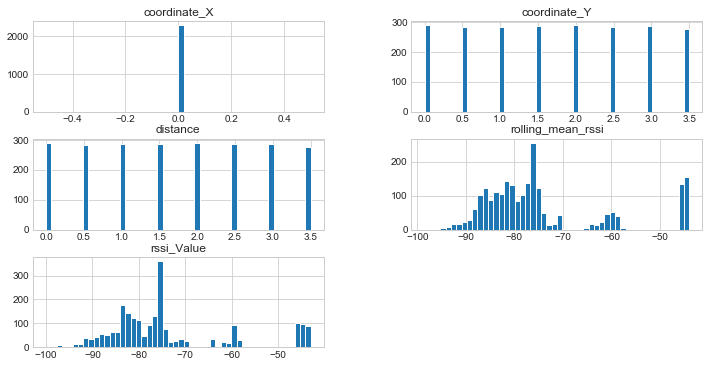

In [7]:
test_dataset_home_small = load_file('../../dataset_test_home.csv')
positions = test_dataset_home_small['coordinate_Y']
test_dataset_home_small['distance'] = positions
replace_features_nan(test_dataset_home_small)
display(test_dataset_home_small)
display(test_dataset_home_small.shape)
test_dataset_home_small.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET ASUS)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,Personal,0.0
1,0.0,0.0,-50,-50.000000,Personal,0.0
2,0.0,0.0,-53,-51.000000,Personal,0.0
3,0.0,0.0,-51,-51.000000,Personal,0.0
4,0.0,0.0,-53,-53.000000,Personal,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,Social,3.5
411,0.0,3.5,-88,-84.500000,Social,3.5
412,0.0,3.5,-84,-84.428571,Social,3.5
413,0.0,3.5,-83,-84.250000,Social,3.5


(415, 6)

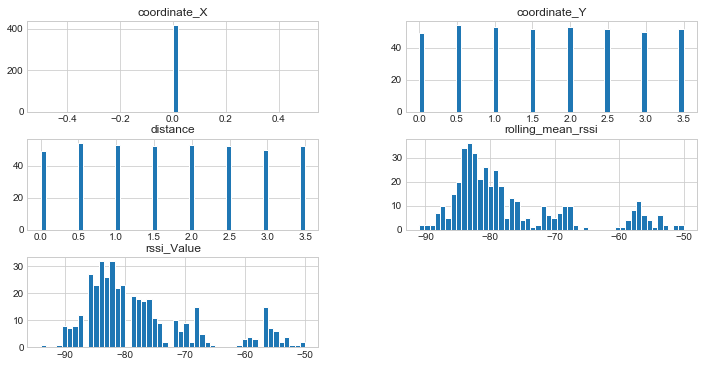

In [8]:
test_dataset_home_asus = load_file('../../dataset_test_home_asus.csv')
positions = test_dataset_home_asus['coordinate_Y']
test_dataset_home_asus['distance'] = positions
replace_features_nan(test_dataset_home_asus)
display(test_dataset_home_asus)
display(test_dataset_home_asus.shape)
test_dataset_home_asus.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [9]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24834 entries, 0 to 24833
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       24834 non-null  float64
 1   coordinate_Y       24834 non-null  float64
 2   rssi_Value         24834 non-null  int64  
 3   rolling_mean_rssi  24834 non-null  float64
 4   zone               24834 non-null  object 
 5   distance           24834 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,24834.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
coordinate_Y,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5
rssi_Value,24834.0,-76.687243,11.255077,-102.0,-84.000000,-78.0,-73.000000,-46.0
rolling_mean_rssi,24834.0,-76.677952,10.969519,-99.0,-83.666667,-78.5,-73.767308,-46.0
distance,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5


### % of Missing Values

In [11]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [12]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

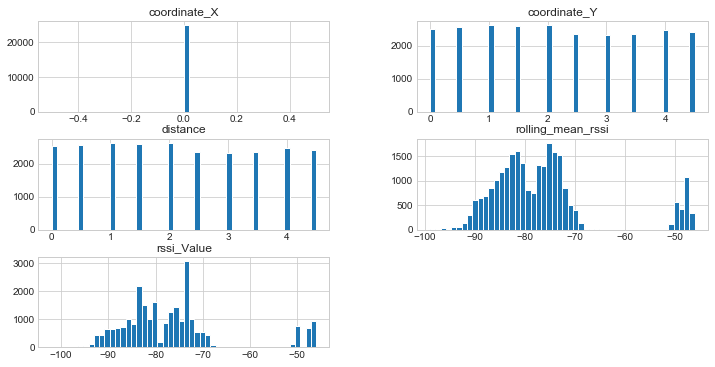

In [13]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Distance
Graphical display of the distances beacon/smartphone scanned in the experiment

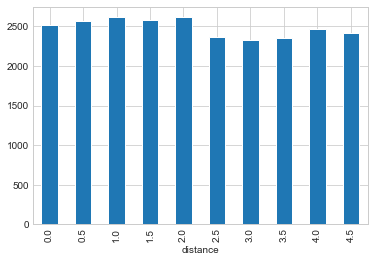

In [14]:
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

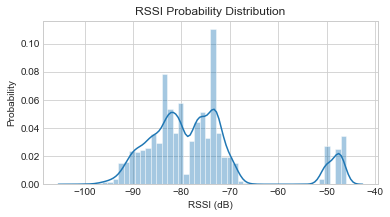

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

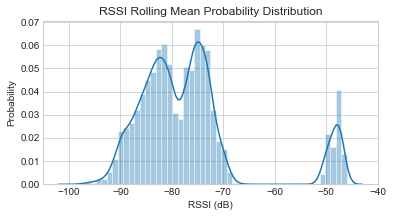

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

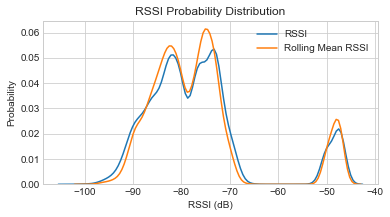

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [18]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

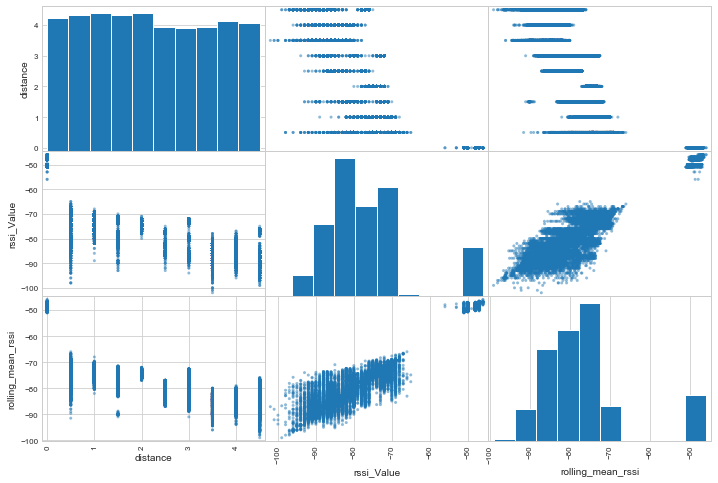

In [19]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [20]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [21]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_big,'rssi_Value')
compute_data_cleaning(test_dataset_home_big,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_small,'rssi_Value')
compute_data_cleaning(test_dataset_home_small,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_asus,'rssi_Value')
compute_data_cleaning(test_dataset_home_asus,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [22]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [23]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed

Previous Categorical Data


,zone
0,Public
1,Public
2,Public
3,Public
4,Public
...,...
3672,Personal
3673,Personal
3674,Personal
3675,Personal


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
categorical_zone = test_dataset_home_big[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_big['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
12470,Social
12471,Social
12472,Social
12473,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
categorical_zone = test_dataset_home_small[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_small['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
2279,Social
2280,Social
2281,Social
2282,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
categorical_zone = test_dataset_home_asus[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_asus['labels'] = test_changed

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
410,Social
411,Social
412,Social
413,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Initialize Training Data
Training Data intialization for predictions purposes

In [28]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)
default_groups = dataset['distance'].map(str)
display(default_groups)

(24834, 1)

(24834, 1)

(24834, 2)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
24829    4.5
24830    4.5
24831    4.5
24832    4.5
24833    4.5
Name: distance, Length: 24834, dtype: object

In [29]:
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
display(train_Y.shape)

(24834, 1)

In [30]:
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-48.351984,-48.325565
0.5,-75.304314,-75.253245
1.0,-74.156908,-74.155786
1.5,-78.266151,-78.279493
2.0,-74.711171,-74.732949
2.5,-82.396866,-82.373984
3.0,-79.297379,-79.557064
3.5,-86.335602,-86.250861
4.0,-84.817666,-84.750632


### Plot Training Data
Graphical Display of the observations in the dataset

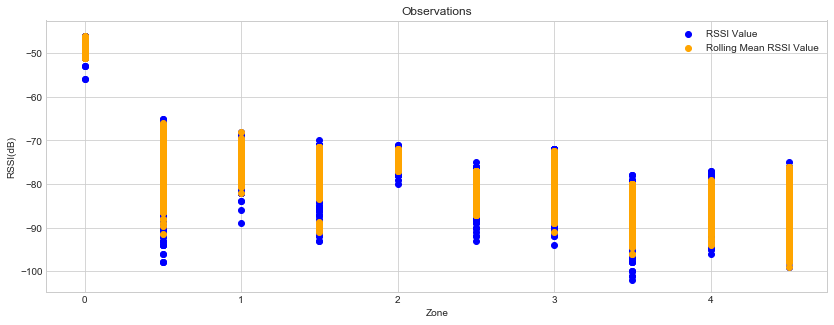

In [31]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [32]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(3677, 1)

(3677, 1)

(3677, 2)

In [33]:
test_Y = pd.DataFrame(test_dataset['distance']).values.reshape(-1,1)
display(test_Y.shape)

(3677, 1)

In [34]:
data_plot_means = test_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-57.010811,-56.935533
0.5,-67.061170,-66.866788
1.0,-75.950685,-76.102343
1.5,-74.568783,-74.328086
2.0,-79.493151,-79.722828
2.5,-76.904891,-76.593561
3.0,-79.255376,-79.142332
3.5,-81.024194,-80.634009
4.0,-80.708108,-80.924987


In [35]:
test_X_rssi_home_big = pd.DataFrame(test_dataset_home_big['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_big.shape)
test_X_rolling_mean_home_big = pd.DataFrame(test_dataset_home_big['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_big.shape)
test_combination_features_X_home_big = test_dataset_home_big[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_big.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [36]:
test_Y_home_big = pd.DataFrame(test_dataset_home_big['distance']).values.reshape(-1,1)
display(test_Y_home_big .shape)

(12475, 1)

In [37]:
data_plot_means = test_dataset_home_big.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-60.626277,-60.688594
Social,-81.402474,-81.424138


In [38]:
test_X_rssi_home_small = pd.DataFrame(test_dataset_home_small['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_small.shape)
test_X_rolling_mean_home_small = pd.DataFrame(test_dataset_home_small['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_small.shape)
test_combination_features_X_home_small = test_dataset_home_small[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_small.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [39]:
test_Y_home_small = pd.DataFrame(test_dataset_home_small['distance']).values.reshape(-1,1)
display(test_Y_home_small .shape)

(2284, 1)

In [40]:
data_plot_means = test_dataset_home_small.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-63.987165,-64.275969
Social,-80.535389,-80.579521


In [41]:
test_X_rssi_home_asus = pd.DataFrame(test_dataset_home_asus['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_asus.shape)
test_X_rolling_mean_home_asus = pd.DataFrame(test_dataset_home_asus['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_asus.shape)
test_combination_features_X_home_asus = test_dataset_home_asus[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_asus.shape)

(415, 1)

(415, 1)

(415, 2)

In [42]:
test_Y_home_asus = pd.DataFrame(test_dataset_home_asus['distance']).values.reshape(-1,1)
display(test_Y_home_small .shape)

(2284, 1)

In [43]:
data_plot_means = test_dataset_home_asus.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-69.205128,-69.220368
Social,-82.181467,-82.010114


### Plot Test Data

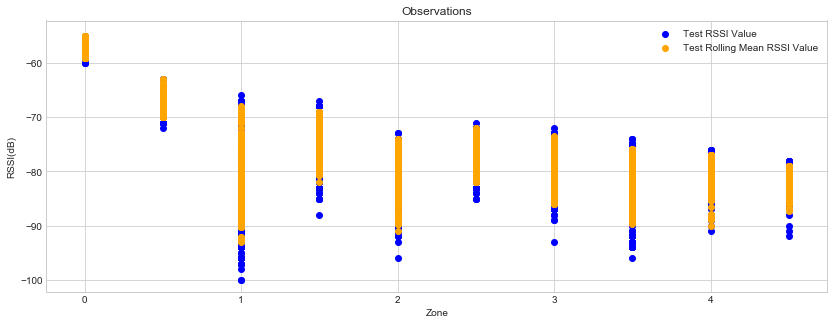

In [44]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['distance'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['distance'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

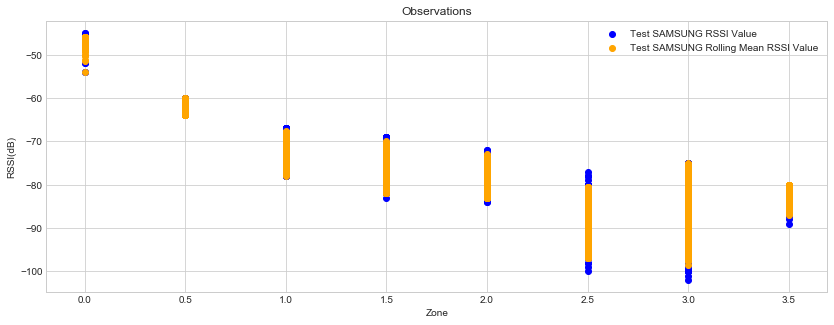

In [45]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_big['distance'],test_dataset_home_big['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_big['distance'],test_dataset_home_big['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

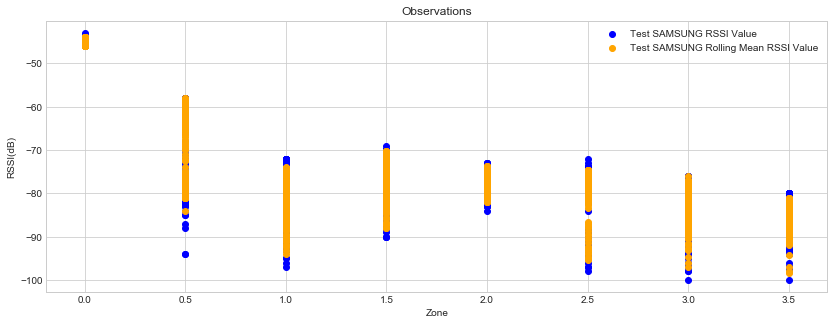

In [46]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_small['distance'],test_dataset_home_small['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_small['distance'],test_dataset_home_small['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

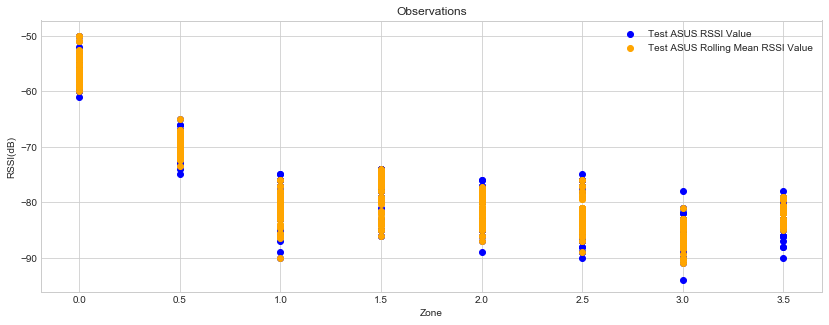

In [47]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_asus['distance'],test_dataset_home_asus['rssi_Value'],label='Test ASUS RSSI Value',color='blue')
plt.scatter(test_dataset_home_asus['distance'],test_dataset_home_asus['rolling_mean_rssi'],label='Test ASUS Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [48]:
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ("linear","poly","rbf","sigmoid")
gamma_list = [10,100,"scale","auto"]
epsilon_list = [0.1,0.2,0.3]

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [49]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.16886274, 0.83113726])

rolling_mean_rssi    0.831137
rssi_Value           0.168863
dtype: float64

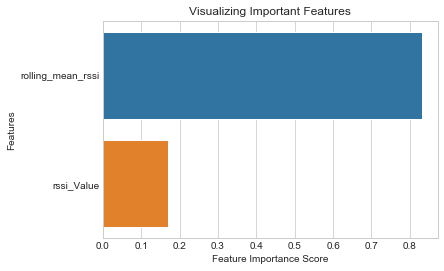

In [50]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestRegressor()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - SVM Regression Model

In [51]:
def compute_SVR(flag=0,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                            cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale",
                epsilon_value =0.1):
    # Init the Linear Regressor Estimator
    svr_estimator = SVR(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,epsilon=epsilon_value)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svr_estimator)
    else:
        main_estimator = svr_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)

#### Check Training model with no cross validation
Use SVM Regressor to check the results on the training data alone

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,-0.019669
1,0.0,-0.019669
2,0.0,-0.019669
3,0.0,-0.019669
4,0.0,0.099887
...,...,...
24829,4.5,4.290808
24830,4.5,4.361992
24831,4.5,4.057369
24832,4.5,4.057369


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.005711
1,0.0,0.005711
2,0.0,0.005711
3,0.0,0.005711
4,0.0,0.014182
...,...,...
24829,4.5,4.101276
24830,4.5,4.110110
24831,4.5,4.108163
24832,4.5,4.106354


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,-0.079376
1,0.0,-0.079376
2,0.0,-0.079376
3,0.0,-0.079376
4,0.0,-0.044722
...,...,...
24829,4.5,4.056043
24830,4.5,3.972788
24831,4.5,4.173495
24832,4.5,4.171740


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,0.591699,0.666401,0.816334,0.816141,-0.423291,-0.039715,0.363155,1.160905,-3.256957,4.876070,0.677071,Both
1,0.659148,0.786450,0.886820,0.884966,-0.421877,0.009761,0.508479,1.389325,-2.556446,3.694564,0.618897,Rolling Mean RSSI
0,0.699077,0.897847,0.947548,0.947416,-0.442631,-0.014756,0.399703,1.485244,-2.514756,3.899975,0.564915,RSSI Only


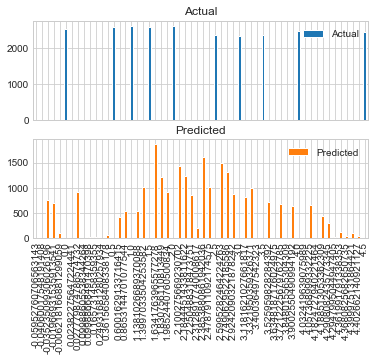

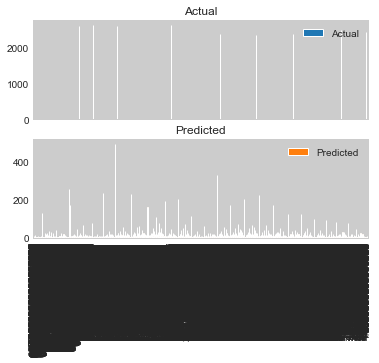

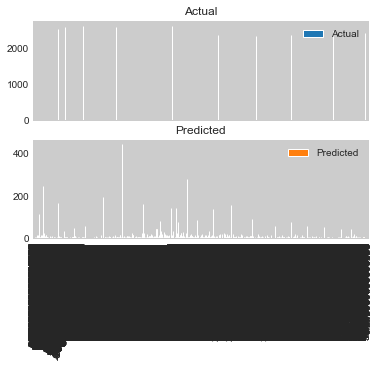

In [52]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    result = compute_SVR(flag=1,trainX_data=trainX_data,trainY_data=train_Y,
                                   testX_data=trainX_data,testY_data=train_Y,
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

#### Experiment - SVM with StratifiedKFold
Experiment using cross validation approach of StratifiedKFold

In [53]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        skf = StratifiedKFold(n_splits=cv)
        splited = skf.split(trainX_data,default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds,type
11,0.593927,0.670485,0.818831,0.818686,-0.424747,-0.022978,0.364352,1.165873,-3.234205,5.265988,0.675092,5,Both
9,0.594915,0.672459,0.820036,0.819977,-0.425161,-0.008198,0.362500,1.167934,-3.140826,5.240412,0.674135,3,Both
10,0.595082,0.672555,0.820094,0.819999,-0.419154,-0.017812,0.365477,1.173727,-3.274870,5.351643,0.674089,4,Both
8,0.596654,0.674434,0.821239,0.821251,-0.420476,0.007692,0.372065,1.180349,-2.856074,5.256037,0.673178,2,Both
7,0.661686,0.788682,0.888078,0.886061,-0.422623,0.016968,0.501570,1.392562,-2.563051,3.728338,0.617815,5,Rolling Mean RSSI
6,0.662500,0.789546,0.888564,0.886511,-0.420227,0.018562,0.499133,1.399263,-2.565032,3.705297,0.617396,4,Rolling Mean RSSI
5,0.663591,0.788926,0.888215,0.886023,-0.418121,0.038077,0.507728,1.387716,-2.571082,3.668201,0.617697,3,Rolling Mean RSSI
4,0.665169,0.789818,0.888717,0.886423,-0.416465,0.048958,0.498665,1.414955,-2.572609,3.653007,0.617265,2,Rolling Mean RSSI
3,0.698912,0.897935,0.947594,0.947464,-0.434393,0.018538,0.399673,1.483437,-2.516256,3.900322,0.564872,5,RSSI Only
2,0.700358,0.899241,0.948283,0.948156,-0.462959,0.020443,0.399467,1.481654,-2.516194,3.899860,0.564240,4,RSSI Only


Number of Folds:  5


#### Experiment - SVM with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

In [54]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=default_groups)
        result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size,type
18,0.580237,0.642194,0.801370,0.801393,-0.416908,-0.033817,0.347360,1.160423,-2.685930,3.738039,0.688639,0.1,Both
22,0.589337,0.664362,0.815084,0.814947,-0.426996,-0.004665,0.352762,1.162756,-2.988066,4.472720,0.678029,0.5,Both
20,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,0.3,Both
23,0.594112,0.669185,0.818037,0.817916,-0.429983,0.021383,0.347429,1.163003,-2.810577,4.781459,0.675719,0.6,Both
21,0.594493,0.672273,0.819922,0.819829,-0.425322,-0.029974,0.352758,1.179775,-3.065675,4.507914,0.674197,0.4,Both
19,0.600939,0.679108,0.824080,0.823861,-0.439055,-0.044557,0.355806,1.181011,-2.675740,4.221069,0.670911,0.2,Both
24,0.601724,0.685286,0.827820,0.827167,-0.443314,0.035307,0.320986,1.142158,-2.769922,5.312394,0.667907,0.7,Both
25,0.608825,0.686054,0.828284,0.828181,-0.437443,0.046934,0.349583,1.156756,-2.730228,4.962638,0.667543,0.8,Both
26,0.620308,0.700869,0.837179,0.837174,-0.420512,0.054786,0.389092,1.183573,-2.647122,4.537334,0.660373,0.9,Both
9,0.641281,0.746509,0.864008,0.861874,-0.395392,0.020353,0.496991,1.348614,-2.487345,3.105256,0.638063,0.1,Rolling Mean RSSI


#### Experiment - SVM with Leave One Group Out
Experiment using cross validation approach of Leave One Group Out

In [55]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,1.118258,1.848259,1.359507,1.337196,-0.845473,0.118518,0.930373,2.756114,-2.904551,5.208347,0.104358,Both
1,1.192637,2.012281,1.418549,1.391377,-0.892582,0.200801,1.067586,2.764986,-2.599894,3.726696,0.024875,Rolling Mean RSSI
0,1.212533,2.134413,1.460963,1.433051,-0.899840,0.005058,1.171731,2.756718,-2.645361,3.925465,-0.034308,RSSI Only


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method,type
7,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,HoldOut,Both
8,0.593927,0.670485,0.818831,0.818686,-0.424747,-0.022978,0.364352,1.165873,-3.234205,5.265988,0.675092,Stratified K-Fold,Both
4,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,HoldOut,Rolling Mean RSSI
5,0.661686,0.788682,0.888078,0.886061,-0.422623,0.016968,0.501570,1.392562,-2.563051,3.728338,0.617815,Stratified K-Fold,Rolling Mean RSSI
1,0.693060,0.885329,0.940919,0.940867,-0.400188,0.009781,0.370394,1.482466,-2.399890,3.900101,0.571050,HoldOut,RSSI Only
2,0.698912,0.897935,0.947594,0.947464,-0.434393,0.018538,0.399673,1.483437,-2.516256,3.900322,0.564872,Stratified K-Fold,RSSI Only
6,1.118258,1.848259,1.359507,1.337196,-0.845473,0.118518,0.930373,2.756114,-2.904551,5.208347,0.104358,LOO,Both
3,1.192637,2.012281,1.418549,1.391377,-0.892582,0.200801,1.067586,2.764986,-2.599894,3.726696,0.024875,LOO,Rolling Mean RSSI
0,1.212533,2.134413,1.460963,1.433051,-0.899840,0.005058,1.171731,2.756718,-2.645361,3.925465,-0.034308,LOO,RSSI Only


Selected cross validation method:  HoldOut


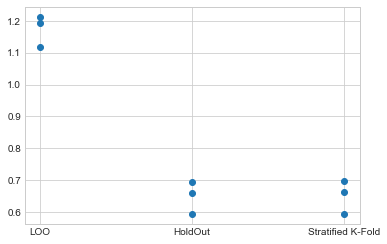

In [56]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
    holdout = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
    loo = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups)
    skfold = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

In [57]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc,type
11,0.592164,0.665633,0.815864,0.815633,-0.435597,-0.033551,0.343215,1.184168,-3.118592,4.255130,0.677494,None,None,Both
8,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
10,0.592953,0.666224,0.816226,0.816019,-0.432150,-0.036146,0.344664,1.183561,-3.128118,4.258517,0.677208,MaxAbsScaler,MaxAbsScaler(copy=True),Both
9,0.593452,0.666534,0.816415,0.816225,-0.429979,-0.037269,0.342586,1.186317,-3.134736,4.258734,0.677058,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
7,0.659348,0.782941,0.884840,0.882649,-0.424171,0.021751,0.497550,1.421204,-2.487080,3.170852,0.620658,None,None,Rolling Mean RSSI
4,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
6,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,MaxAbsScaler,MaxAbsScaler(copy=True),Rolling Mean RSSI
5,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI
3,0.693060,0.885329,0.940919,0.940867,-0.400188,0.009781,0.370394,1.482466,-2.399890,3.900101,0.571050,None,None,RSSI Only
2,0.693060,0.885329,0.940919,0.940867,-0.400188,0.009781,0.370394,1.482466,-2.399890,3.900101,0.571050,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only


Selected Preprocessing:  None


#### Experiment - Running the SVR function with the different kernels

In [58]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','kernel','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for kernel in kernel_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),kernel_parameter=kernel)
        result.append(kernel)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_kernel = statistics.sort_values(by=['mae'])['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,kernel,type
10,0.592932,6.662838e-01,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,rbf,Both
6,0.659400,7.829167e-01,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,rbf,Rolling Mean RSSI
2,0.693060,8.853295e-01,0.940919,0.940867,-0.400188,0.009781,0.370394,1.482466,-2.399890,3.900101,0.571050,rbf,RSSI Only
8,0.773234,9.409391e-01,0.970020,0.969316,-0.632616,-0.023119,0.533505,1.601548,-2.263439,2.608949,0.544106,linear,Both
4,0.774465,9.446862e-01,0.971950,0.971405,-0.640468,-0.033622,0.521726,1.600001,-2.271982,2.581467,0.542291,linear,Rolling Mean RSSI
0,0.786432,9.869075e-01,0.993432,0.993463,-0.682659,0.017768,0.487384,1.580001,-2.337509,3.147298,0.521834,linear,RSSI Only
9,0.932174,1.338884e+00,1.157102,1.151689,-0.890917,0.021722,0.640624,1.647681,-5.203740,9.454401,0.351298,poly,Both
5,1.000457,1.421532e+00,1.192280,1.192106,-1.008754,-0.068523,0.881155,1.890104,-2.109325,1.989085,0.311255,poly,Rolling Mean RSSI
1,1.001024,1.406514e+00,1.185965,1.185756,-1.000222,-0.089250,0.873397,1.882215,-2.115769,2.430924,0.318531,poly,RSSI Only
11,785.341441,1.510695e+06,1229.103313,1207.113710,-595.865151,-0.786430,448.490427,3536.930599,-2438.037551,3794.583287,-731944.629729,sigmoid,Both


Selected Kernel:  rbf


#### Experiment - Running the SVR function with the different C parameters

In [59]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','C_parameter','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for C_param in C_parameter_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                 C_parameter=C_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                 C_parameter=C_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),C_parameter=C_param)
        result.append(C_param)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_c_parameter = statistics.sort_values(by=['mae'])['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,C_parameter,type
17,0.567737,0.658619,0.811553,0.811172,-0.363792,0.005909,0.260158,1.184272,-2.951112,4.654547,0.680893,1000.00,Both
16,0.575318,0.654955,0.809293,0.808907,-0.388596,-0.017351,0.314578,1.173618,-2.873654,3.920415,0.682668,100.00,Both
15,0.585653,0.661902,0.813573,0.813132,-0.421261,-0.037026,0.318567,1.161902,-3.662587,4.100014,0.679303,10.00,Both
14,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,1.00,Both
13,0.598166,0.670551,0.818872,0.818906,-0.428298,0.038424,0.347861,1.196892,-2.609329,4.136943,0.675112,0.50,Both
12,0.607360,0.680785,0.825097,0.825135,-0.419022,0.059157,0.351730,1.202587,-2.549682,3.830858,0.670154,0.25,Both
10,0.658578,0.781779,0.884182,0.882726,-0.423463,-0.051810,0.504441,1.420169,-2.541673,3.152474,0.621221,100.00,Rolling Mean RSSI
11,0.659100,0.783272,0.885027,0.883087,-0.420027,0.031060,0.508864,1.422147,-2.563492,3.125519,0.620497,1000.00,Rolling Mean RSSI
8,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,1.00,Rolling Mean RSSI
9,0.659820,0.781162,0.883833,0.882458,-0.427238,-0.048235,0.493928,1.419681,-2.507835,3.175304,0.621520,10.00,Rolling Mean RSSI


Selected C Parameter:  1000.0


#### Experiment - Running the SVR function with the different gamma parameters

In [60]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','gamma','gammaStr','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for gamma_param in gamma_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),gamma_parameter=gamma_param)
        result.append(gamma_param)
        result.append(str(gamma_param))
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_gamma = statistics.sort_values(by=['mae'])['gamma'].head(1).values[0]
print("Selected Gamma Parameter: ",selected_gamma)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,gamma,gammaStr,type
9,0.466534,0.596780,0.772515,0.772389,-0.126887,0.009435,0.099908,1.224330,-3.188651,3.970823,0.710855,100,100,Both
8,0.520238,0.599767,0.774446,0.773184,-0.332140,-0.044015,0.169681,1.078256,-3.005352,3.968599,0.709407,10,10,Both
10,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,scale,scale,Both
11,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,auto,auto,Both
1,0.617132,0.860973,0.927887,0.927743,-0.100459,0.099485,0.100303,1.400430,-3.100075,3.899766,0.582850,100,100,RSSI Only
5,0.630669,0.782568,0.884629,0.884582,-0.370437,0.046926,0.392374,1.383792,-3.106772,3.248616,0.620839,100,100,Rolling Mean RSSI
4,0.651225,0.776018,0.880919,0.878123,-0.393437,-0.025734,0.529574,1.416998,-2.412162,3.038591,0.624012,10,10,Rolling Mean RSSI
6,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,scale,scale,Rolling Mean RSSI
7,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,auto,auto,Rolling Mean RSSI
0,0.659479,0.893719,0.945367,0.936384,-0.599920,0.000752,0.100519,1.352762,-2.599858,3.899955,0.566985,10,10,RSSI Only


Selected Gamma Parameter:  100


#### Experiment - Running the SVR function with the different epsilon parameters

In [61]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','epsilon','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for epsilon in epsilon_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                 epsilon_value=epsilon)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                 epsilon_value=epsilon)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),epsilon_value=epsilon)
        result.append(epsilon)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
selected_epsilon = statistics.sort_values(by=['mae'])['epsilon'].head(1).values[0]
print("Selected Epsilon: ",selected_epsilon)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,epsilon,type
6,0.592932,0.666284,0.816262,0.816058,-0.431413,-0.036585,0.343393,1.183181,-3.131926,4.261286,0.677179,0.1,Both
7,0.607632,0.669546,0.818258,0.818228,-0.459608,0.075358,0.340234,1.147734,-2.769362,4.218967,0.675599,0.2,Both
8,0.627901,0.678833,0.823913,0.823917,-0.490840,0.067295,0.339084,1.138545,-2.766823,4.128098,0.671099,0.3,Both
3,0.659400,0.782917,0.884826,0.882649,-0.424077,0.021970,0.497678,1.420757,-2.487600,3.170989,0.620670,0.1,Rolling Mean RSSI
4,0.674856,0.780554,0.883490,0.882601,-0.472027,0.118714,0.467277,1.372593,-2.592273,3.163731,0.621814,0.2,Rolling Mean RSSI
5,0.689946,0.787005,0.887133,0.887073,-0.520598,0.090596,0.433755,1.319586,-2.682110,3.158498,0.618689,0.3,Rolling Mean RSSI
0,0.693060,0.885329,0.940919,0.940867,-0.400188,0.009781,0.370394,1.482466,-2.399890,3.900101,0.571050,0.1,RSSI Only
1,0.710454,0.888410,0.942555,0.941568,-0.418576,0.105109,0.374255,1.479480,-2.394891,3.799780,0.569557,0.2,RSSI Only
2,0.721475,0.892685,0.944820,0.944533,-0.482356,0.019167,0.431397,1.413789,-2.480833,3.711263,0.567486,0.3,RSSI Only


Selected Epsilon:  0.1


### Run RandomizedSearchCV  for parameter tunning

In [62]:
results = []
tuned_parameters = {
    'svr__kernel':['rbf'],
    'svr__C':C_parameter_list,
    'svr__gamma':gamma_list,
    'svr__epsilon':epsilon_list
}
scores = ['r2']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('svr', SVR())])
        clf = RandomizedSearchCV(pipe, tuned_parameters,n_iter=100,n_jobs=-1,cv=StratifiedKFold(n_splits=selected_fold, shuffle=True, random_state=42).split(trainX_data, default_groups),scoring=score,verbose=1
        )
        clf.fit(trainX_data,train_Y.ravel())
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for r2

Fitting 5 folds for each of 72 candidates, totalling 360 fits


D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
D:\Programs\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 235.7min finished
D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.4min
D:\Programs\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 88.8min finished
D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
D:\Programs\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 334.6min finished


,svr__kernel,svr__gamma,svr__epsilon,svr__C,score,best_score,type
2,rbf,10,0.3,100.00,r2,0.724667,Both
1,rbf,10,0.2,0.25,r2,0.622855,Rolling Mean RSSI
0,rbf,10,0.3,10.00,r2,0.596479,RSSI Only


### Best Parameters
Display the best parameters tunned throughout the experiments

In [63]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Epsilon']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma,selected_epsilon]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,C Parameter,Cross Validation,Kernel,Preprocessing,Gamma,Epsilon
0,1000.0,HoldOut,rbf,None,100,0.1


### Best Results
Compute SVR with the best parameters in both RSSI and Rolling Mean

In [64]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
results = list()
final_results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y,groups=default_groups.ravel())
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                             kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y,scaler=StandardScaler(),cross_validation = splited,
                             kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y, test_size = 0.3, random_state = 42,stratify=default_groups)
        result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler(),
                             kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
final_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type
2,0.471081,0.650059,0.806262,0.806187,-0.112019,0.012259,0.099761,1.353657,-7.359330,4.171189,0.685040,Both
0,0.616785,0.860876,0.927834,0.927699,-0.100324,0.099690,0.100441,1.400220,-3.100549,3.900283,0.582898,RSSI Only
1,0.629258,0.785287,0.886164,0.886203,-0.409320,0.054535,0.327922,1.398202,-3.414947,3.398518,0.619521,Rolling Mean RSSI


### Best Results - Testing data (Different Beacon)
Experiment with testing dataset

In [65]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVR(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,epsilon=selected_epsilon)
        else: 
            model = SVR()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
final_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,2.899478
1,4.5,3.899913
2,4.5,2.600428
3,4.5,3.899913
4,4.5,4.400373
...,...,...
3672,0.0,1.195361
3673,0.0,0.099509
3674,0.0,0.099509
3675,0.0,0.099509


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,1.710584
1,4.5,1.710584
2,4.5,1.710584
3,4.5,1.710584
4,4.5,1.710584
...,...,...
3672,0.0,1.710584
3673,0.0,1.710584
3674,0.0,1.710584
3675,0.0,1.710584


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,3.401151
1,4.5,3.398448
2,4.5,3.429325
3,4.5,3.468610
4,4.5,3.364914
...,...,...
3672,0.0,2.250145
3673,0.0,2.250145
3674,0.0,2.250145
3675,0.0,2.250145


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,1.827714
1,4.5,1.827714
2,4.5,1.827714
3,4.5,1.827714
4,4.5,1.827714
...,...,...
3672,0.0,1.827714
3673,0.0,1.827714
3674,0.0,1.827714
3675,0.0,1.827714


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,2.600729
1,4.5,3.898294
2,4.5,2.601793
3,4.5,3.877457
4,4.5,4.101915
...,...,...
3672,0.0,2.546301
3673,0.0,2.546301
3674,0.0,2.546301
3675,0.0,2.546301


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,4.5,0.012476
1,4.5,0.012476
2,4.5,0.012476
3,4.5,0.012476
4,4.5,0.012476
...,...,...
3672,0.0,0.012476
3673,0.0,0.012476
3674,0.0,0.012476
3675,0.0,0.012476


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
0,0.967155,1.628771,1.276233,1.236672,-1.100130,-0.100521,0.099945,2.100185,-3.100433,3.400393,0.201675,RSSI Only,True
2,1.082622,1.899658,1.378281,1.353226,-1.146871,-0.396263,0.101450,2.250145,-2.908812,3.401594,0.068903,Rolling Mean RSSI,True
3,1.274117,2.202682,1.484144,1.428563,-1.672286,-0.172286,0.827714,1.827714,-2.672286,1.827714,-0.079621,Rolling Mean RSSI,False
1,1.296383,2.310819,1.520138,1.428563,-1.789416,-0.289416,0.710584,1.710584,-2.789416,1.710584,-0.132623,RSSI Only,False
4,1.304620,2.911370,1.706274,1.690474,-1.135398,-0.445212,0.267689,2.546301,-12.455121,15.253707,-0.426976,Both,True
5,2.220794,6.961015,2.638374,1.428563,-3.487524,-1.987524,-0.987524,0.012476,-4.487524,0.012476,-2.411866,Both,False


### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 BIG Dataset)
Experiment with testing dataset

In [66]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_big
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_big
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_big
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVR(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,epsilon=selected_epsilon)
        else: 
            model = SVR()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y_home_big,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_big.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
final_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.099837
1,0.0,0.100343
2,0.0,0.100343
3,0.0,0.099837
4,0.0,0.099837
...,...,...
12470,3.5,3.399739
12471,3.5,3.399739
12472,3.5,3.399739
12473,3.5,3.399739


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.710584
1,0.0,1.710584
2,0.0,1.710584
3,0.0,1.710584
4,0.0,1.710584
...,...,...
12470,3.5,1.710584
12471,3.5,1.710584
12472,3.5,1.710584
12473,3.5,1.710584


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.079304
1,0.0,-0.001219
2,0.0,-0.007442
3,0.0,-0.001219
4,0.0,0.012810
...,...,...
12470,3.5,3.399321
12471,3.5,3.401069
12472,3.5,3.401053
12473,3.5,3.399284


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.827714
1,0.0,1.827714
2,0.0,1.827714
3,0.0,1.827714
4,0.0,1.827714
...,...,...
12470,3.5,1.827714
12471,3.5,1.827714
12472,3.5,1.827714
12473,3.5,1.827714


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.011948
1,0.0,-0.038186
2,0.0,-0.046504
3,0.0,0.099839
4,0.0,0.053389
...,...,...
12470,3.5,3.352103
12471,3.5,3.392158
12472,3.5,3.401930
12473,3.5,3.399405


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.012476
1,0.0,0.012476
2,0.0,0.012476
3,0.0,0.012476
4,0.0,0.012476
...,...,...
12470,3.5,0.012476
12471,3.5,0.012476
12472,3.5,0.012476
12473,3.5,0.012476


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
2,0.731374,0.898415,0.947848,0.890182,-0.268082,0.112627,0.805484,1.750145,-1.931472,2.249083,0.314361,Rolling Mean RSSI,True
0,0.740333,0.887356,0.941996,0.914127,-0.399944,0.100209,0.899658,1.605604,-1.899692,1.900393,0.322801,RSSI Only,True
4,0.893006,1.537669,1.240028,1.223052,-0.531259,0.055377,0.876374,2.046301,-11.342818,19.737183,-0.173495,Both,True
1,0.999761,1.310652,1.144837,1.144743,-0.789416,0.210584,0.710584,1.710584,-1.789416,1.710584,-0.000244,RSSI Only,False
3,1.002437,1.320184,1.148993,1.144743,-0.672286,0.327714,0.827714,1.827714,-1.672286,1.827714,-0.007519,Rolling Mean RSSI,False
5,1.719115,4.254923,2.062746,1.144743,-2.487524,-1.487524,-0.987524,0.012476,-3.487524,0.012476,-2.247208,Both,False


### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 Small Dataset)
Experiment with testing dataset

In [67]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_small
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_small
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_small
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVR(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,epsilon=selected_epsilon)
        else: 
            model = SVR()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y_home_small,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_small.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
final_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,2.035736
1,0.0,2.035736
2,0.0,2.035736
3,0.0,2.035736
4,0.0,1.334098
...,...,...
2279,3.5,3.899913
2280,3.5,3.400163
2281,3.5,3.400163
2282,3.5,4.400373


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.710584
1,0.0,1.710584
2,0.0,1.710584
3,0.0,1.710584
4,0.0,1.710584
...,...,...
2279,3.5,1.710584
2280,3.5,1.710584
2281,3.5,1.710584
2282,3.5,1.710584


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,2.182314
1,0.0,2.182314
2,0.0,2.182314
3,0.0,2.182314
4,0.0,2.122477
...,...,...
2279,3.5,3.755192
2280,3.5,3.696071
2281,3.5,3.641940
2282,3.5,3.406502


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.827714
1,0.0,1.827714
2,0.0,1.827714
3,0.0,1.827714
4,0.0,1.827714
...,...,...
2279,3.5,1.827714
2280,3.5,1.827714
2281,3.5,1.827714
2282,3.5,1.827714


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,2.543392
1,0.0,2.543392
2,0.0,2.543392
3,0.0,2.543392
4,0.0,2.487491
...,...,...
2279,3.5,3.903005
2280,3.5,3.599836
2281,3.5,3.596509
2282,3.5,3.954519


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.012476
1,0.0,0.012476
2,0.0,0.012476
3,0.0,0.012476
4,0.0,0.012476
...,...,...
2279,3.5,0.012476
2280,3.5,0.012476
2281,3.5,0.012476
2282,3.5,0.012476


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
0,0.892814,1.336439,1.156044,1.045019,-0.100433,0.399720,1.100334,2.100334,-1.899692,3.899946,-0.022526,RSSI Only,True
2,0.893288,1.372856,1.171690,1.030662,-0.194516,0.367222,1.148569,2.387025,-1.743309,3.407834,-0.050390,Rolling Mean RSSI,True
1,0.997085,1.308149,1.143744,1.143490,-0.789416,0.210584,0.710584,1.710584,-1.789416,1.710584,-0.000882,RSSI Only,False
3,0.997290,1.313917,1.146262,1.143490,-0.672286,0.327714,0.827714,1.827714,-1.672286,1.827714,-0.005295,Rolling Mean RSSI,False
4,1.172628,2.536653,1.592687,1.414073,-0.304624,0.434480,1.656244,2.595435,-3.281792,17.738722,-0.940825,Both,True
5,1.735208,4.306998,2.075331,1.143490,-2.487524,-1.487524,-0.987524,0.012476,-3.487524,0.012476,-2.295338,Both,False


### Best Results - Home Testing data (using data recovered from ASUS ZENFONE LIVE)
Experiment with testing dataset

In [68]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_asus
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_asus
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_asus
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = SVR(C=selected_c_parameter,kernel=selected_kernel,gamma=selected_gamma,epsilon=selected_epsilon)
        else: 
            model = SVR()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y)
        predict_test = model.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(test_Y_home_asus,predict_test)
        statistical_array = list()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_asus.flatten(), 'Predicted':predict_test.flatten()})
        display(error_dataframe)
        observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
        error = pd.DataFrame(observed_errors, columns=["error"])
        result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
        data = structure_data(result,coefficient_determination)
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
final_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.100172
1,0.0,0.100172
2,0.0,0.099870
3,0.0,0.099931
4,0.0,0.099870
...,...,...
410,3.5,2.899478
411,3.5,3.599739
412,3.5,3.899913
413,3.5,2.600428


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.710584
1,0.0,1.710584
2,0.0,1.710584
3,0.0,1.710584
4,0.0,1.710584
...,...,...
410,3.5,1.710584
411,3.5,1.710584
412,3.5,1.710584
413,3.5,1.710584


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.079308
1,0.0,0.079308
2,0.0,0.099827
3,0.0,0.099827
4,0.0,2.182294
...,...,...
410,3.5,3.869225
411,3.5,3.400335
412,3.5,3.406502
413,3.5,3.468610


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,1.827714
1,0.0,1.827714
2,0.0,1.827714
3,0.0,1.827714
4,0.0,1.827714
...,...,...
410,3.5,1.827714
411,3.5,1.827714
412,3.5,1.827714
413,3.5,1.827714


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.053673
1,0.0,0.053673
2,0.0,2.385373
3,0.0,0.099827
4,0.0,2.543779
...,...,...
410,3.5,3.400126
411,3.5,3.862599
412,3.5,3.878602
413,3.5,2.602654


D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Actual,Predicted
0,0.0,0.012476
1,0.0,0.012476
2,0.0,0.012476
3,0.0,0.012476
4,0.0,0.012476
...,...,...
410,3.5,0.012476
411,3.5,0.012476
412,3.5,0.012476
413,3.5,0.012476


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
0,0.862584,1.126058,1.061159,0.951689,-0.099763,0.400163,0.900149,1.900163,-2.100433,2.900159,0.130477,RSSI Only,True
2,0.960265,1.440375,1.200156,1.030041,-0.043899,0.605283,1.089375,2.250145,-1.908812,2.760864,-0.112233,Rolling Mean RSSI,True
1,0.992074,1.296536,1.138655,1.139367,-0.789416,0.210584,0.710584,1.710584,-1.789416,1.710584,-0.001163,RSSI Only,False
3,0.992356,1.301163,1.140685,1.139367,-0.672286,0.327714,0.827714,1.827714,-1.672286,1.827714,-0.004736,Rolling Mean RSSI,False
4,1.127203,2.010751,1.418009,1.287381,-0.071769,0.550810,1.261952,2.546301,-4.090208,3.409072,-0.552668,Both,True
5,1.739868,4.311926,2.076518,1.139367,-2.487524,-1.487524,-0.987524,0.012476,-3.487524,0.012476,-2.329596,Both,False


### Results Display

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,type,Tuning
0,0.471081,0.650059,0.806262,0.806187,-0.112019,0.012259,0.099761,1.353657,-7.359330,4.171189,0.685040,Both,None
2,0.731374,0.898415,0.947848,0.890182,-0.268082,0.112627,0.805484,1.750145,-1.931472,2.249083,0.314361,Rolling Mean RSSI,True
4,0.862584,1.126058,1.061159,0.951689,-0.099763,0.400163,0.900149,1.900163,-2.100433,2.900159,0.130477,RSSI Only,True
3,0.892814,1.336439,1.156044,1.045019,-0.100433,0.399720,1.100334,2.100334,-1.899692,3.899946,-0.022526,RSSI Only,True
1,0.967155,1.628771,1.276233,1.236672,-1.100130,-0.100521,0.099945,2.100185,-3.100433,3.400393,0.201675,RSSI Only,True


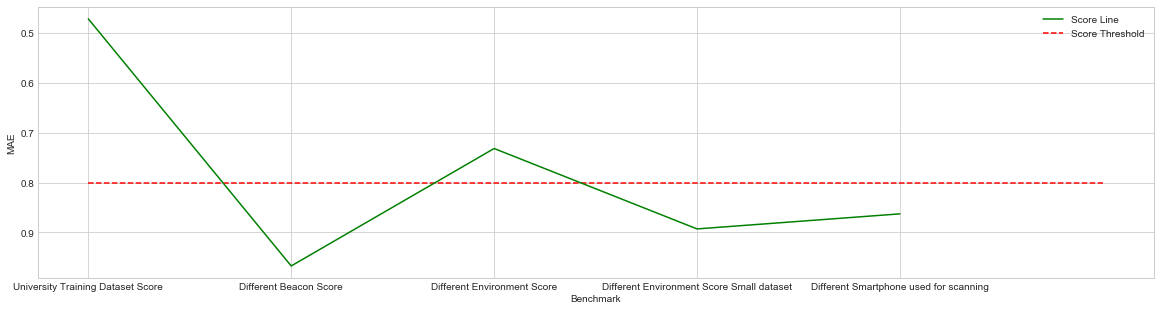

In [69]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type','Tuning']
types = ['University Training Dataset Score','Different Beacon Score','Different Environment Score','Different Environment Score Small dataset',
        "Different Smartphone used for scanning"]
results = pd.DataFrame(data=final_results,columns=statistical_cols)
display(results.sort_values(by=['mae']))
plt.figure(figsize=(20,5))
plt.plot(types,results['mae'],color='green',label='Score Line')
plt.hlines(0.8,0,5,color='red',label='Score Threshold',linestyles='dashed')
plt.xlabel('Benchmark')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.show()